In [169]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import pandas as pd
from scipy.ndimage import convolve
import time
from PIL import Image
import os
import ipyplot
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer

In [166]:
kernel0 = np.array([
                [-1, 0.0, 1],
                [-2, 0.0, 2],
                [-1, 0.0, 1]])
kernel1= np.array([
                [-1,-2,-1],
                [0.0,0.0,0.0],
                [1,2,1]])

def convolve_img(img, kernel):
    return convolve(img, kernel) 
def brightness(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
def partial_derivative(img):
    grx = convolve_img(img, kernel0)
    gry = convolve_img(img, kernel1)
    return grx, gry

def get_edgeness(img):
    grx, gry = partial_derivative(img)
    maxx = float('-inf')
    edged = [[ 0 for _ in range(len(grx[0]))] for _ in range(len(grx))]
    for i in range(len(grx)):
        for j in range(len(grx[0])):
            edged[i][j] = ((grx[i][j])**2  + (gry[i][j])**2)**0.5
            if edged[i][j] > maxx:
                maxx = edged[i][j]
    
    for i in range(len(grx)):
        for j in range(len(grx[0])):
            edged[i][j] /= maxx
    return edged

def least_edgy_ver(edged_img):
    least_e = np.zeros_like(edged_img)
    dirs = np.zeros_like(edged_img)
    for i in range(len(edged_img[0])):
        least_e[-1][i] = edged_img[-1][i]
    m, n = len(edged_img), len(edged_img[0])

    for i in range(m-2,-1,-1):
        for j in range(n):
            j1, j2 = max(0, j-1), min(j+1, n-1)
            min_e = float('inf')
            direction = 0
            for pi,k in enumerate(least_e[i+1][j1:j2+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            
            least_e[i][j] = edged_img[i][j] + min_e
            dirs[i][j] = (-1,0,1)[direction + (j==0)]

    return least_e, dirs

def least_edgy_hor(edged_img):
    least_e = np.zeros_like(edged_img)
    dirs = np.zeros_like(edged_img)
    for i in range(len(edged_img)):
        least_e[i][-1] = edged_img[i][-1]
    m, n = len(edged_img), len(edged_img[0])
    for j in range(n-2, -1, -1):
        for i in range(m):
            i1, i2 = max(0, i-1), min(i+1, m-1)
            min_e = float('inf')
            direction = 0
            for pi, k in enumerate(least_e[i1:i2+1,j+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            least_e[i][j] += edged_img[i][j] + min_e
            dirs[i][j] = (-1,0,1)[direction + (i==0)]
    return least_e, dirs


def get_seam_at_ver(dirs, j):
    m = len(dirs)
    js = [0 for _ in range(m)]
    js[0] = j
    for i in range(1, m):
        js[i] = js[i-1]+dirs[i-1][int(js[i-1])]
    return js

def get_seam_at_hor(dirs, i):
    n = len(dirs[0])
    js = [0 for _ in range(n)]
    js[0] = i
    for j in range(1, n):
        js[j] = js[j-1] + dirs[int(js[j-1])][j-1]

    return js

def rm_path_ver(img, path):
    img = np.array(img)
    n = len(img[0])
    cut_img = img[:, :-1].copy()

    for i, j in enumerate(path):
        j = int(j)
        cut_img[i,:j] = img[i,:j]
        cut_img[i,j:] = img[i,j+1:]

    return cut_img

def rm_path_hor(img, path):
    img = np.array(img)
    m = len(img)
    cut_img = img[:-1, :].copy()
    # print(len(cut_img), len(img))
    for i, j in enumerate(path):
        #i is col and j is row here
        j = int(j)
        cut_img[:j,i] = img[:j,i]
        cut_img[j:,i] = img[j+1:,i]

    return cut_img

# def shrink_horizontally(img,edged,org, n):
#     new_img = np.copy(img)
#     org_i = np.copy(org)
#     for i in range(n):  
#         dp, dirs = least_edgy_ver(edged)
#         m_col = float('inf')
#         col = 0
#         for j in range(0,len(dp[0])):
#             if m_col > dp[0][j]:
#                 m_col = dp[0][j]
#                 col = j 
#         seam = get_seam_at_ver(dirs, col)
#         new_img = rm_path_ver(new_img, seam)
#         org_i = rm_path_ver(org_i, seam)
#         edged = rm_path_ver(edged, seam)

#     return new_img, org_i

# def shrink_vertically(img,edged, n):
#     new_img = np.copy(img)
#     for i in range(n):
#         dp, dirs = least_edgy_hor(edged)
#         m_row = float('inf')
#         row = 0
#         for j in range(0,len(dp)):
#             if m_row > dp[j][0]:
#                 m_row = dp[j][0]
#                 row = j
#         seam = get_seam_at_hor(dirs, row)
#         new_img = rm_path_hor(new_img, seam)
#         edged = rm_path_hor(edged, seam)

#     return new_img
def recompute_dir_neighbours_ver(seam, dirs, dp, edged_img):
    m = len(dp)
    n = len(dp[0])
    for i in range(len(seam)-2, -1,-1):
        j = int(seam[i])
        if j == 0:
            # If we removed 0 column then we have to update 0 column
            j1, j2 = 0, 1
            min_e = float('inf')
            direction = 0
            for pi,k in enumerate(dp[i+1][j1:j2+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            dp[i][0] += edged_img[i][0]+min_e
            dirs[i][0] = (0,1)[direction]
        elif j == n:
            j = j-1
            # If we removed n-1 column then we have to update n-1 column
            j1, j2 = j-1, j
            min_e = float('inf')
            direction = 0
            for pi,k in enumerate(dp[i+1][j1:j2+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            dp[i][j] += edged_img[i][j] + min_e
            dirs[i][j] = (-1, 0)[direction]
        else:
            if j-1>=0:
                j1, j2 = max(0, j-2), min(j, n-1)
                min_e = float('inf')
                direction = 0
                for pi,k in enumerate(dp[i+1][j1:j2+1]):
                    if k < min_e:
                        min_e = k
                        direction = pi
                dp[i][j-1] += edged_img[i][j-1] + min_e
                dirs[i][j-1] = (-1,0,1)[direction + ((j-1)==0)]
            if j<n-1:
                j1, j2 = max(0, j-1), min(j+1, n-1)
                min_e = float('inf')
                direction = 0
                for pi,k in enumerate(dp[i+1][j1:j2+1]):
                    if k < min_e:
                        min_e = k
                        direction = pi
                dp[i][j] += edged_img[i][j] + min_e
                dirs[i][j] = (-1,0,1)[direction + (j==0)]
            
        
    return dp, dirs
def recompute_dir_neighbours_hor(seam, dirs, dp, edged):
    m = len(dirs)
    n = len(dirs[0])
    for j in range(len(seam)-2,-1,-1):
        i = int(seam[j])
        if i == 0:
            i1, i2 = 0, 1
            # print(i1, i2, i)
            min_e = float('inf')
            direction = 0
            for pi, k in enumerate(dp[i1:i2+1,j+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            dp[0][j] += edged[0][j] + min_e
            dirs[0][j] = (0,1)[direction]
        elif i == m:
            i = i-1
            i1, i2 = i-1, i
            min_e = float('inf')
            direction = 0
            for pi, k in enumerate(dp[i1:i2+1,j+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            dp[i][j] += edged[i][j] + min_e
            dirs[i][j] = (-1,0)[direction]
        else:
            i1, i2 = max(0, i-2), min(i, m-1)
            # print(i1, i2, i)
            min_e = float('inf')
            direction = 0
            for pi, k in enumerate(dp[i1:i2+1,j+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            dp[i-1][j] += edged[i-1][j] + min_e
            dirs[i-1][j] = (-1,0,1)[direction+((i-1)==0)]
            i1, i2 = max(0, i-1), min(i+1, m-1)
            min_e = float('inf')
            direction = 0
            for pi, k in enumerate(dp[i1:i2+1,j+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            dp[i][j] += edged[i][j] + min_e
            dirs[i][j] = (-1,0,1)[direction+(i==0)]
        
    return dp, dirs
def shrink_horizontally(img,edged,imgorg, n):
    new_img = np.copy(img)
    org_img = np.copy(imgorg)
    dp, dirs = least_edgy_ver(edged)
    for i in range(n):  
        col = np.argmin(dp[0])
        seam = get_seam_at_ver(dirs, col)
        new_img = rm_path_ver(new_img, seam)
        org_img = rm_path_ver(org_img, seam)
        dp = rm_path_ver(dp, seam)
        dirs = rm_path_ver(dirs, seam)
        # edged = get_edgeness(new_img)
        edged = rm_path_ver(edged, seam)
        dp, dirs = recompute_dir_neighbours_ver(seam,dirs,dp,edged)

    return new_img, org_img


    
def shrink_vertically(img,edged,imgorg, n):
    new_img = np.copy(img)
    org_img = np.copy(imgorg)
    dp, dirs = least_edgy_hor(edged)
    for i in range(n):
        row = np.argmin(dp[:,0])
        seam = get_seam_at_hor(dirs, row)
        new_img = rm_path_hor(new_img, seam)
        org_img = rm_path_hor(org_img, seam)
        dp = rm_path_hor(dp, seam)
        dirs = rm_path_hor(dirs, seam)
        edged = rm_path_hor(edged, seam)
        dp, dirs = recompute_dir_neighbours_hor(seam, dirs, dp, edged)

    return new_img, org_img

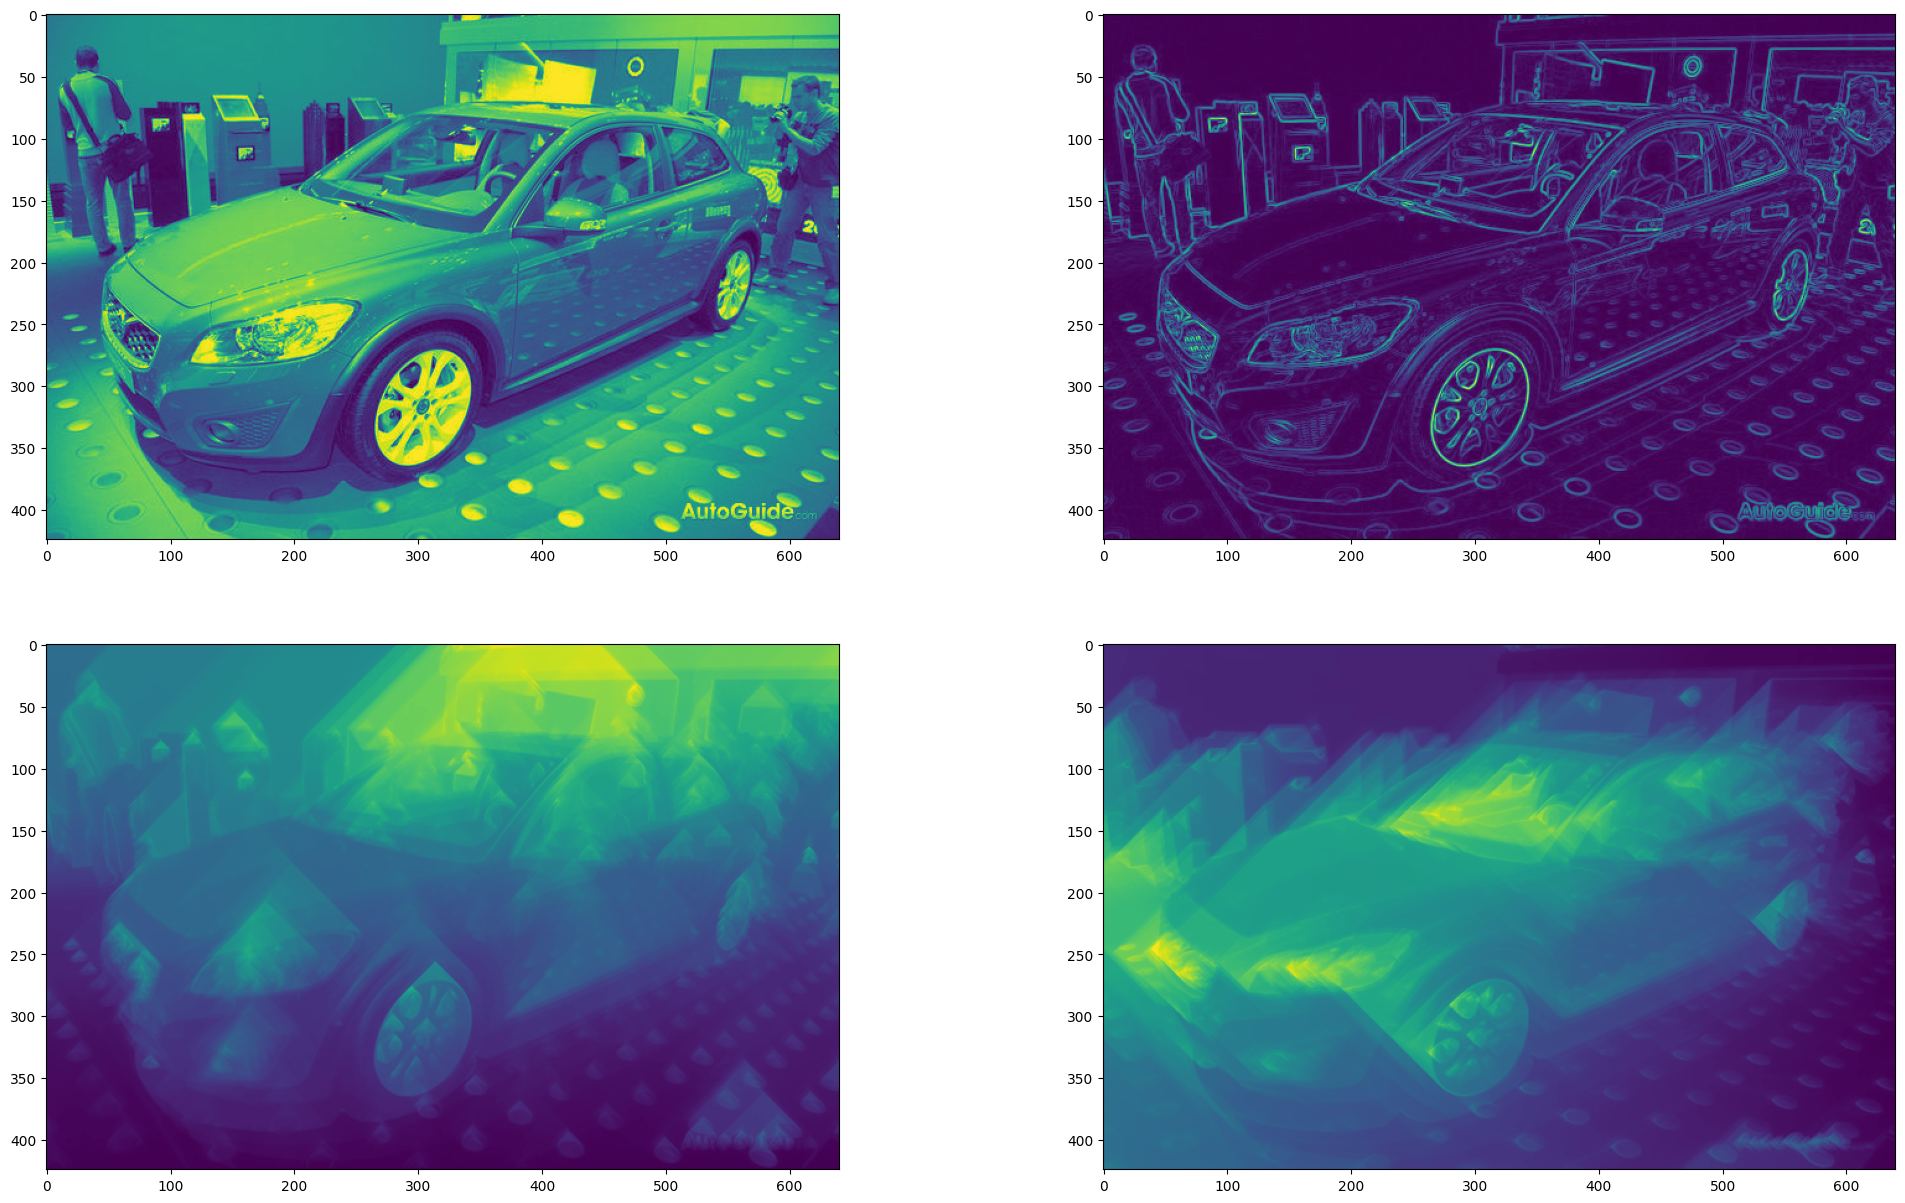

In [167]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
imgorg = Image.open('../Cars/Original/00015.jpg')
# imgorg = Image.open('img1.jpg')
imgorg = np.array(imgorg)
img = brightness(imgorg)
fig, axes = plt.subplots(2, 2, figsize=(25, 15))
edged = get_edgeness(img)
dp1, dirs1 = least_edgy_ver(edged)
dp2, dirs2 = least_edgy_hor(edged)
axes[0][0].imshow(img)
axes[0][1].imshow(edged)
axes[1][0].imshow(dp1)
axes[1][1].imshow(dp2)

It took 7s to shrink horizontally by 192px and vertically by 127px


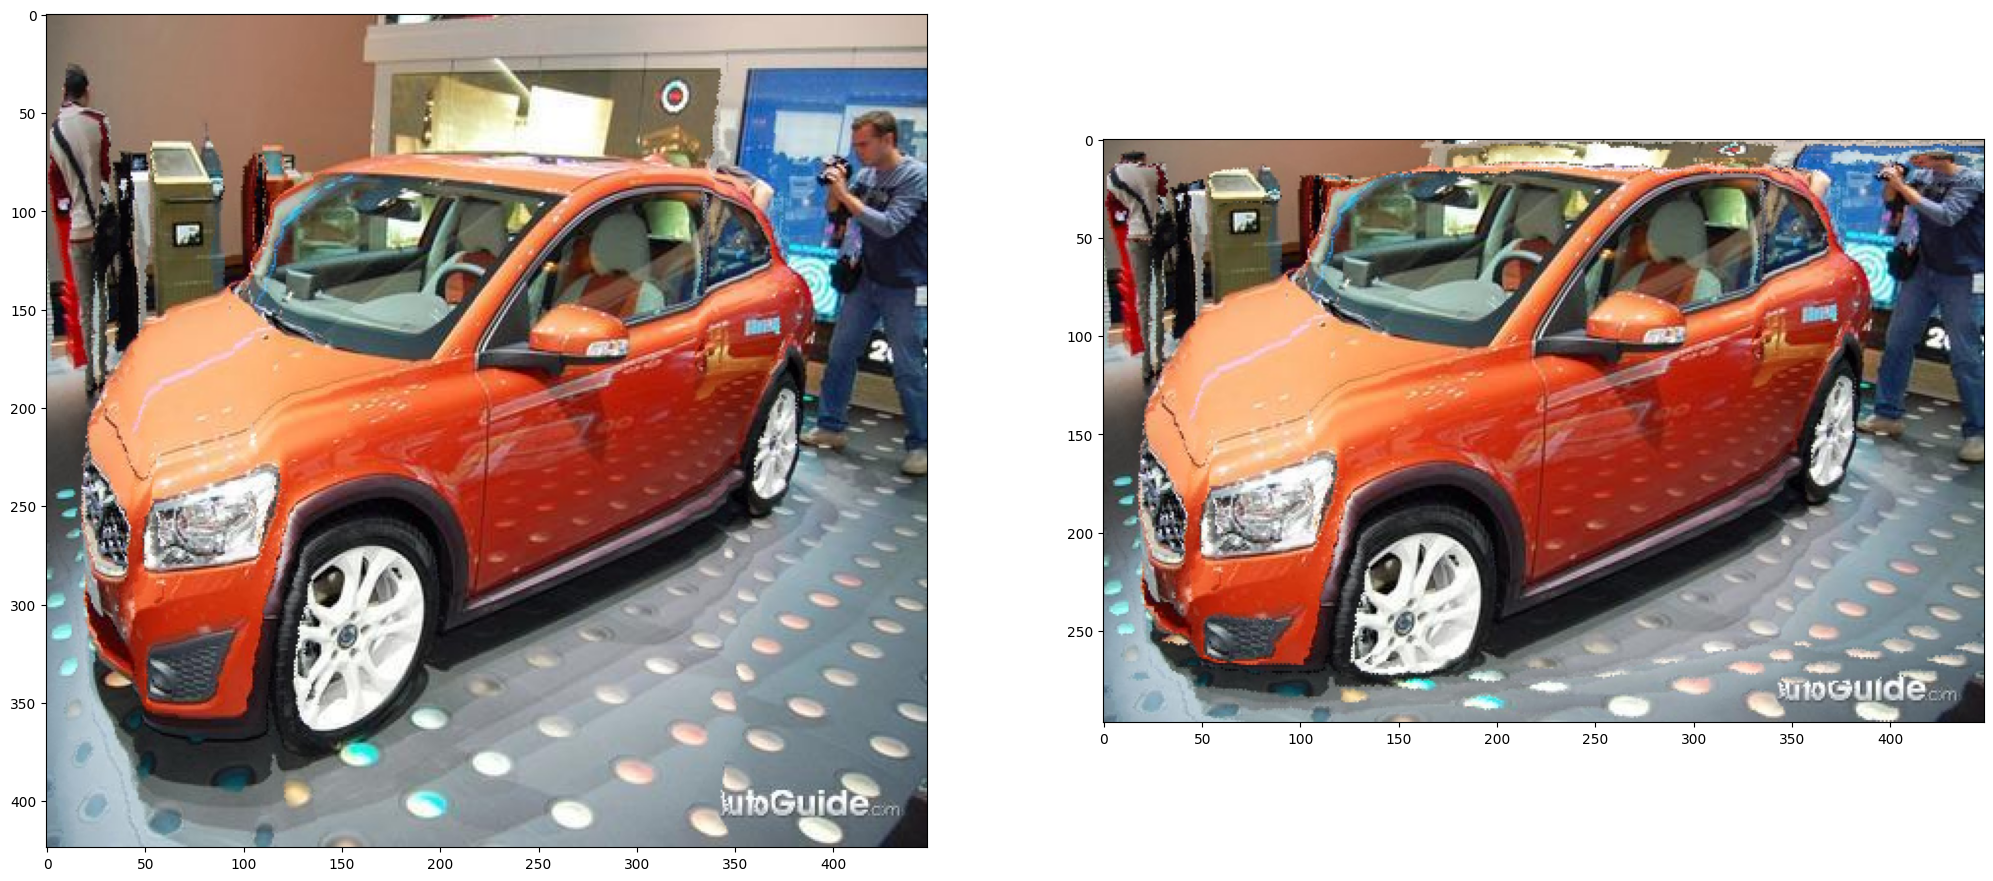

In [168]:
# horPx = img.shape[1] - 2
# verPx = img.shape[0] - 300
scale = 0.3
horPx = round(img.shape[1] * scale)
verPx = round(img.shape[0] * scale)
fig, axes = plt.subplots(1, 2, figsize=(25, 15))
start = time.time() 
edged = get_edgeness(img)
img1 = shrink_horizontally(img,edged,imgorg,horPx)
edged = get_edgeness(img1[0])
img2 = shrink_vertically(img1[0],edged,img1[1],verPx)
img_from_array = Image.fromarray(img2[1])
img_from_array.save("new_image.jpg")
axes[0].imshow(img1[1])
axes[1].imshow(img2[1])
end = time.time()
print("It took "+str(round(end - start))+"s to shrink horizontally by "+str(horPx)+"px and vertically by "+str(verPx)+"px")

In [162]:
# data1 = {"labels":[10, 20, 30, 40, 50], "images":[]}
# for per in data1["labels"]:
#     scale = per/100
#     horPx = round(img.shape[1] * scale)
#     verPx = round(img.shape[0] * scale)
#     edged = get_edgeness(img)
#     img1 = shrink_horizontally(img,edged,imgorg,horPx)
#     edged = get_edgeness(img1[0])
#     img2 = shrink_vertically(img1[0],edged,img1[1],verPx)
#     final = np.transpose(processor(img2[1]).pixel_values[0], (1, 2, 0))
#     data1["images"].append(final)
# fig, axes = plt.subplots(3, 2, figsize=(10, 10))
# axes[0][0].imshow(data1["images"][0])
# axes[0][1].imshow(data1["images"][1])
# axes[1][0].imshow(data1["images"][2])
# axes[1][1].imshow(data1["images"][3])
# axes[2][0].imshow(data1["images"][4])


In [182]:
df = pd.read_csv('../Cars/stanford_cars_with_class_names - train.csv',header=0,encoding='utf-8')
df.head(5)
df = df[df['class'] <= 12]
df.head()

id  x1  y1   x2   y2  class             ture_class_name      image
0  162  46  84  661  428      1  AM General Hummer SUV 2000  00163.jpg
1  461   5   8   83   58      1  AM General Hummer SUV 2000  00462.jpg
2  521   6   7   94   68      1  AM General Hummer SUV 2000  00522.jpg
3  706  26  32  677  418      1  AM General Hummer SUV 2000  00707.jpg
4  772  33  50  197  150      1  AM General Hummer SUV 2000  00773.jpg

In [ ]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
count = 0
path = '../Cars/Original/'
savePath = '../Cars/Resized/'
start = time.time() 
# for file in os.listdir(path):
for file in df['image']:
    if file.split('.')[-1] != 'jpg':
        continue
    print("Processing file "+str(count+1)+":"+file)
    imgorg = Image.open(path+file)
    imgorg = np.array(imgorg)
    img = rgb2gray(imgorg)
    scale = 0.3
    horPx = round(img.shape[1] * scale)
    verPx = round(img.shape[0] * scale)
    edged = get_edgeness(img)
    img1 = shrink_horizontally(img,edged,imgorg,horPx)
    edged = get_edgeness(img1[0])
    img2 = shrink_vertically(img1[0],edged,img1[1],verPx)
    final = np.transpose(processor(img2[1], do_normalize=False, rescale_factor=1).pixel_values[0], (1, 2, 0))
    img_from_array = Image.fromarray(final.astype(np.uint8))
    img_from_array.save(savePath+file.split('.')[0]+"_sc.jpg")
    count += 1
end = time.time()

print("Time taken to process "+str(count + 1)+" images ~ "+str(round((end-start)/60))+" mins")

Processing file 1:00163.jpg
Processing file 2:00462.jpg
Processing file 3:00522.jpg
Processing file 4:00707.jpg
Processing file 5:00773.jpg
Processing file 6:00887.jpg
Processing file 7:00946.jpg
Processing file 8:01277.jpg
Processing file 9:01661.jpg
Processing file 10:01832.jpg
Processing file 11:01918.jpg
Processing file 12:01952.jpg
Processing file 13:02050.jpg
Processing file 14:02145.jpg
Processing file 15:02311.jpg
Processing file 16:02363.jpg
Processing file 17:02848.jpg
Processing file 18:03008.jpg
Processing file 19:03393.jpg
